In [4]:
from Bio import SeqIO, pairwise2
from Bio.PDB import PDBParser, Superimposer, PPBuilder, PDBIO
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

C:\Users\ralme\anaconda3\envs\BIO\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Bloque 1 - Descarga de secuencia desde UniProt

En este apartado, se lleva a cabo la descarga de la proteína **Beta-2-microglobulin (B2M)** desde UniProt. Además, se verifica su contenido mostrando por pantalla la longitud total y los primeros 20 aminoácidos de la secuencia.

In [5]:
fasta_path = "data/P61769.fasta.txt"

record = SeqIO.read(fasta_path, "fasta")

sequence = record.seq

print("ID de la secuencia:", record.id)
print("Descripción:", record.description)
print("Longitud total de la secuencia:", len(sequence))
print("Primeros 20 aminoácidos:", sequence[:20])

ID de la secuencia: sp|P61769|B2MG_HUMAN
Descripción: sp|P61769|B2MG_HUMAN Beta-2-microglobulin OS=Homo sapiens OX=9606 GN=B2M PE=1 SV=1
Longitud total de la secuencia: 119
Primeros 20 aminoácidos: MSRSVALAVLALLSLSGLEA


# Bloque 2 – Visualización del modelo AlphaFold

En este bloque se visualiza el modelo estructural predicho por AlphaFold para la beta-2-microglobulina
(UniProt P61769) utilizando la librería py3Dmol. El objetivo es comprobar que el modelo descargado coincide
con la visualización mostrada en la web de AlphaFold y analizar la forma general de la proteína.

In [6]:
with open("data/AF-P61769-F1-model_v6.pdb") as f:
    pdb_data = f.read()

view = py3Dmol.view(width=800, height=500)
view.addModel(pdb_data, "pdb")

view.setStyle({"cartoon": {}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Tras cargar el archivo PDB en Python, se observa que la estructura presenta una conformación compacta y
globular, dominada por un núcleo de láminas β característico del plegamiento tipo inmunoglobulina. Además,
se distingue una región helicoidal alargada que se extiende desde el núcleo principal, asociada a una zona
más flexible de la proteína.

La comparación con la visualización disponible en la página de AlphaFold muestra una alta concordancia
estructural, confirmando que el modelo tridimensional descargado y visualizado en Python reproduce
fielmente la estructura predicha por AlphaFold.

# Bloque 3 - Extraer pLDDT del PDB


En este apartado se analiza la calidad del modelo estructural predicho por AlphaFold a partir de los valores
de pLDDT almacenados en el campo B-factor del archivo PDB. Estos valores proporcionan una estimación de la
confianza local de la predicción estructural para cada residuo de la proteína.

En primer lugar, se carga el archivo PDB correspondiente al modelo AlphaFold de la beta-2-microglobulina
utilizando el módulo `Bio.PDB`. La estructura se recorre jerárquicamente para acceder a modelos, cadenas,
residuos y átomos.



In [7]:
pdb_path = "data/AF-P61769-F1-model_v6.pdb"

parser = PDBParser(QUIET=True)
structure = parser.get_structure("B2M", pdb_path)

plddt_por_residuo = defaultdict(list)

for model in structure:
    for chain in model:
        for residue in chain:
            if residue.id[0] != " ":
                continue

            residuo_id = (chain.id, residue.id[1])

            for atom in residue:
                plddt = atom.get_bfactor()
                plddt_por_residuo[residuo_id].append(plddt)

Dado que cada residuo contiene múltiples átomos, se asigna un único valor de pLDDT por residuo calculando
el promedio de los valores de sus átomos. Esto permite evaluar la confianza estructural a nivel de residuo.


In [8]:
plddt_residuos = {
    residuo: np.mean(valores)
    for residuo, valores in plddt_por_residuo.items()
}

plddt_values = list(plddt_residuos.values())

In [9]:
plddt_medio = np.mean(plddt_values)

residuos_alta_confianza = [
    v for v in plddt_values if v > 70
]

porcentaje_alta_confianza = (
    len(residuos_alta_confianza) / len(plddt_values)
) * 100

print(f"Número total de residuos analizados: {len(plddt_values)}")
print(f"pLDDT medio de la estructura: {plddt_medio:.2f}")
print(f"Porcentaje de residuos con pLDDT > 70: {porcentaje_alta_confianza:.2f}%")

Número total de residuos analizados: 119
pLDDT medio de la estructura: 94.04
Porcentaje de residuos con pLDDT > 70: 94.12%


### Conclusión

El análisis de los valores de pLDDT muestra que el modelo estructural predicho por AlphaFold para la
beta-2-microglobulina presenta una calidad global muy alta. El pLDDT medio obtenido (94.04) se sitúa dentro
del rango asociado a predicciones altamente fiables, y más del 94 % de los residuos presentan valores de
pLDDT superiores a 70.

Estos resultados indican que la estructura tridimensional generada es robusta y adecuada para análisis
estructurales posteriores, como la visualización detallada de la proteína o el estudio de la relación
estructura-función.

### Bloque 4 – Representación gráfica del pLDDT por residuo

En este bloque se representa gráficamente la calidad de la predicción estructural obtenida con AlphaFold
mediante un gráfico lineal de los valores de pLDDT por residuo. Este tipo de representación permite evaluar
cómo varía la confianza de la predicción a lo largo de la secuencia de la proteína e identificar regiones
estructuralmente más estables o potencialmente más flexibles.

A partir de los valores de pLDDT calculados en el bloque anterior, se ordenan los residuos según su posición
en la secuencia y se construyen los vectores necesarios para la representación gráfica. El eje X representa
el índice del residuo, mientras que el eje Y corresponde al valor de pLDDT asignado a cada residuo.


In [10]:
residuos_ordenados = sorted(plddt_residuos.keys(), key=lambda x: x[1])

residue_indices = [res[1] for res in residuos_ordenados]

plddt_por_residuo_ordenado = [
    plddt_residuos[res] for res in residuos_ordenados
]

Se genera un gráfico lineal en el que cada punto representa el valor de pLDDT de un residuo. Además, se añade
una línea horizontal en pLDDT = 70, que actúa como umbral de referencia para distinguir visualmente las regiones
predichas con alta confianza de aquellas con menor fiabilidad.

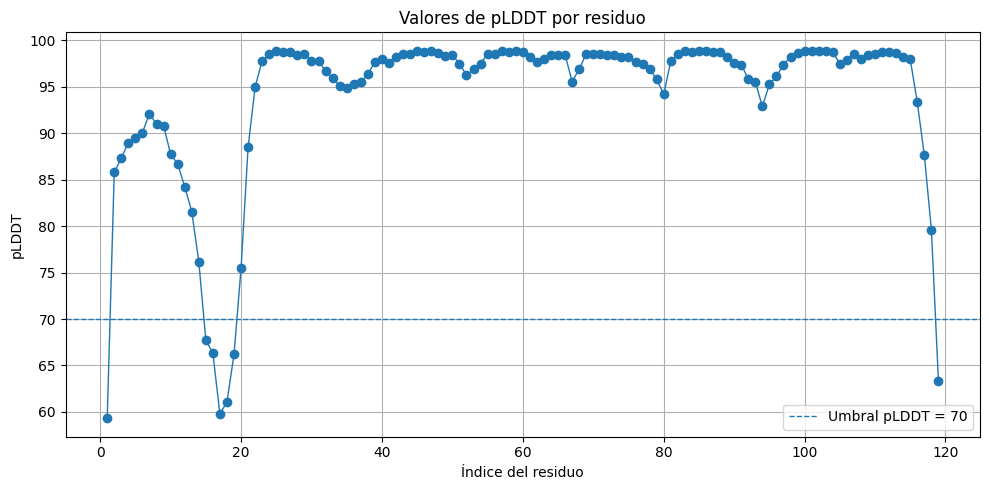

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(
    residue_indices,
    plddt_por_residuo_ordenado,
    marker='o',
    linewidth=1
)

plt.axhline(
    y=70,
    linestyle='--',
    linewidth=1,
    label='Umbral pLDDT = 70'
)

plt.xlabel("Índice del residuo")
plt.ylabel("pLDDT")
plt.title("Valores de pLDDT por residuo")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Interpretación del gráfico pLDDT por residuo

El gráfico de pLDDT por residuo muestra que la mayor parte de la secuencia presenta valores de pLDDT muy elevados,
generalmente por encima de 90 y claramente superiores al umbral de 70, lo que indica una **alta confianza en la
predicción estructural** a lo largo de casi toda la proteína.

Las regiones comprendidas aproximadamente entre los residuos 25 y 110 presentan valores de pLDDT cercanos a 95–99,
lo que sugiere que estas zonas corresponden al **núcleo estructural más estable** de la proteína. Este comportamiento
es coherente con la presencia de un plegamiento tipo inmunoglobulina bien definido, característico de la
beta-2-microglobulina.

Por el contrario, se observa una disminución clara de los valores de pLDDT en los **extremos de la secuencia**,
especialmente en los primeros residuos (región N-terminal) y en los últimos residuos (región C-terminal), donde
los valores llegan a situarse por debajo del umbral de 70. Estas regiones probablemente corresponden a zonas más
flexibles o menos estructuradas, lo cual es habitual en los extremos de proteínas globulares.

El gráfico confirma que el modelo predicho por AlphaFold es **altamente fiable en la mayor parte de la
secuencia**, mientras que las regiones con menor pLDDT se concentran en zonas específicas asociadas a mayor
flexibilidad conformacional.

# Bloque 5 – Visualización de la estructura coloreada por pLDDT

En este bloque se visualiza la estructura tridimensional de la beta-2-microglobulina aplicando el esquema
de colores oficial de AlphaFold, que representa el nivel de confianza de la predicción estructural a partir
de los valores de pLDDT almacenados en el campo B-factor del archivo PDB.

AlphaFold utiliza un código de colores estándar para representar la confianza de la predicción:

- **Azul oscuro**: pLDDT > 90 (muy alta confianza)
- **Cian / azul claro**: confianza alta
- **Amarillo**: confianza intermedia
- **Naranja / rojo**: baja confianza, asociado a regiones flexibles o desordenadas


In [12]:
with open("data/AF-P61769-F1-model_v6.pdb") as f:
    pdb_data = f.read()

view = py3Dmol.view(width=800, height=500)
view.addModel(pdb_data, "pdb")

view.setStyle({
    "cartoon": {
        "colorscheme": {
            "prop": "b",
            "gradient": "roygb",
            "min": 50,
            "max": 100
        }
    }
})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Tras aplicar este esquema de colores en py3Dmol, se observa que la distribución de regiones de alta y baja
confianza coincide con la mostrada en la web de AlphaFold. El núcleo estructural de la proteína aparece mayoritariamente en tonos azules, indicando valores altos de pLDDT y, por tanto, una alta fiabilidad en la predicción estructural de estas regiones. En contraste, las zonas más periféricas y la región helicoidal alargada presentan colores más claros o amarillentos, lo que sugiere una menor confianza relativa y una mayor flexibilidad conformacional, algo habitual en extremos o regiones menos estructuradas.

# Bloque 6 – Comparación con una estructura experimental

Con el objetivo de evaluar la precisión de la predicción estructural generada por AlphaFold, se comparó el
modelo predicho con una estructura experimental de la beta-2-microglobulina disponible en el Protein Data
Bank (PDB). Ambas estructuras se alinearon utilizando los átomos Cα de los residuos equivalentes y se calculó
el RMSD como medida de similitud estructural global

In [13]:
af_path = "data/AF-P61769-F1-model_v6.pdb"
exp_path = "data/2D4F.pdb"   

parser = PDBParser(QUIET=True)
ppb = PPBuilder()

af_struct = parser.get_structure("AF", af_path)
exp_struct = parser.get_structure("EXP", exp_path)

af_chain = list(af_struct[0].get_chains())[0]
exp_chain = list(exp_struct[0].get_chains())[0]

af_seq = str(ppb.build_peptides(af_chain)[0].get_sequence())
exp_seq = str(ppb.build_peptides(exp_chain)[0].get_sequence())

aln = pairwise2.align.globalxx(af_seq, exp_seq, one_alignment_only=True)[0]
af_aln, exp_aln = aln.seqA, aln.seqB

af_residues = [res for res in af_chain if res.id[0] == " " and "CA" in res]
exp_residues = [res for res in exp_chain if res.id[0] == " " and "CA" in res]

af_idx = 0
exp_idx = 0

af_ca_atoms = []
exp_ca_atoms = []

for a, b in zip(af_aln, exp_aln):
    if a != "-" and b != "-":
        af_ca_atoms.append(af_residues[af_idx]["CA"])
        exp_ca_atoms.append(exp_residues[exp_idx]["CA"])
    if a != "-":
        af_idx += 1
    if b != "-":
        exp_idx += 1
        
sup = Superimposer()
sup.set_atoms(exp_ca_atoms, af_ca_atoms)  
rmsd = sup.rms

sup.apply(list(af_struct.get_atoms()))

print("Número de Cα emparejados:", len(af_ca_atoms))
print(f"RMSD (Cα) AlphaFold vs experimental: {rmsd:.3f} Å")

Número de Cα emparejados: 98
RMSD (Cα) AlphaFold vs experimental: 4.350 Å


El alineamiento permitió emparejar un total de 98 átomos Cα, lo que representa una fracción significativa de
la secuencia total de la proteína. El valor de RMSD obtenido fue de **4.350 Å**, lo que indica una concordancia
global moderada entre el modelo predicho y la estructura experimental.

In [14]:
io = PDBIO()
io.set_structure(af_struct)
io.save("data/AF_aligned_to_exp.pdb")

with open("data/AF_aligned_to_exp.pdb") as f:
    af_pdb = f.read()

with open(exp_path) as f:
    exp_pdb = f.read()

view = py3Dmol.view(width=900, height=500)

# Experimental (gris)
view.addModel(exp_pdb, "pdb")
view.setStyle({"model": 0}, {"cartoon": {"color": "lightgray"}})

# AlphaFold alineado (azul)
view.addModel(af_pdb, "pdb")
view.setStyle({"model": 1}, {"cartoon": {"color": "steelblue"}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

La visualización superpuesta de ambas estructuras muestra que el núcleo estructural de la proteína, dominado
por láminas β características del plegamiento tipo inmunoglobulina, presenta una buena coincidencia espacial.
Sin embargo, se observan diferencias más acusadas en regiones periféricas, en particular en la región
helicoidal alargada, que adopta orientaciones distintas en ambos modelos.

Estas discrepancias pueden atribuirse a la mayor flexibilidad conformacional de dichas regiones, así como a
diferencias en las condiciones experimentales bajo las cuales se resolvió la estructura experimental. En
conjunto, los resultados indican que AlphaFold reproduce correctamente la arquitectura global de la
beta-2-microglobulina, aunque existen variaciones locales que afectan al valor global de RMSD.

# Bloque 7 – Mapa de distancias internas Cα–Cα

En este bloque se analiza la organización espacial de la proteína generando un mapa de distancias internas
entre todos los átomos Cα del modelo de AlphaFold. Para ello, se extraen las coordenadas 3D de cada Cα y se
construye una matriz dist[i, j] que contiene la distancia entre los residuos i y j.

Este mapa de calor permite identificar regiones compactas (distancias pequeñas y patrón denso) y regiones
más extendidas o flexibles (distancias mayores y zonas más difusas). Finalmente, se relaciona este patrón
estructural con la confianza del modelo (pLDDT).

Primero se carga el archivo PDB de AlphaFold y se extraen, en orden, los residuos que contienen un átomo Cα.
Para cada residuo se almacenan sus coordenadas tridimensionales. Esto permite trabajar con una lista ordenada
de posiciones (una por residuo) para calcular el mapa de distancias.


In [15]:
pdb_path = "data/AF-P61769-F1-model_v6.pdb"

parser = PDBParser(QUIET=True)
structure = parser.get_structure("B2M_AF", pdb_path)

chain = list(structure[0].get_chains())[0]

ca_coords = []
res_indices = []   
res_keys = []      

for residue in chain:
    if residue.id[0] != " ":
        continue
    if "CA" not in residue:
        continue

    resseq = residue.id[1]
    ca = residue["CA"].get_coord()

    ca_coords.append(ca)
    res_indices.append(resseq)
    res_keys.append((chain.id, resseq))

ca_coords = np.array(ca_coords)

print("Número de Cα extraídos:", len(ca_coords))
print("Primeros residuos:", res_indices[:10])

Número de Cα extraídos: 119
Primeros residuos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


A continuación se calcula la matriz de distancias Cα–Cα. Cada entrada dist[i, j] representa la distancia
euclídea entre el Cα del residuo i y el Cα del residuo j. La matriz resultante es simétrica y su diagonal
es cero.

In [16]:
diff = ca_coords[:, None, :] - ca_coords[None, :, :]
dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))

print("Matriz de distancias:", dist_matrix.shape)
print("Distancia mínima (no diagonal):", np.min(dist_matrix[np.nonzero(dist_matrix)]))
print("Distancia máxima:", np.max(dist_matrix))


Matriz de distancias: (119, 119)
Distancia mínima (no diagonal): 3.0748982
Distancia máxima: 76.10871


Se representa la matriz de distancias como un mapa de calor. Los valores bajos indican residuos cercanos en el
espacio (regiones compactas), mientras que los valores altos corresponden a residuos alejados (regiones extendidas).

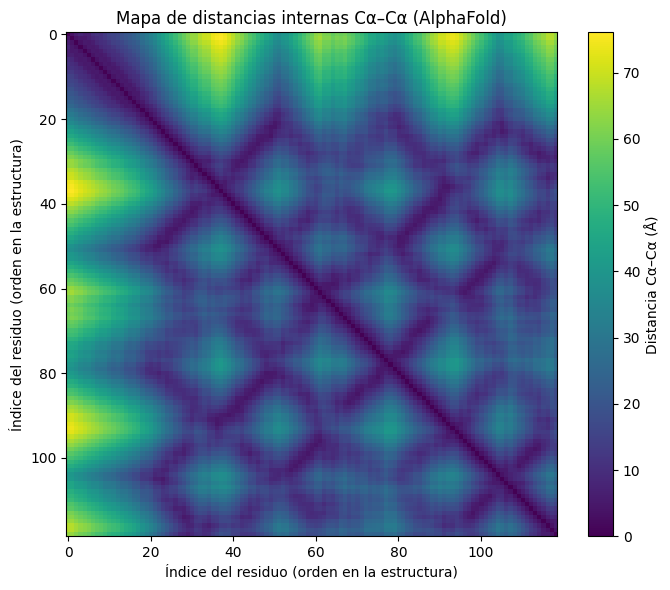

In [17]:
plt.figure(figsize=(7, 6))
plt.imshow(dist_matrix, aspect="auto")
plt.colorbar(label="Distancia Cα–Cα (Å)")
plt.title("Mapa de distancias internas Cα–Cα (AlphaFold)")
plt.xlabel("Índice del residuo (orden en la estructura)")
plt.ylabel("Índice del residuo (orden en la estructura)")
plt.tight_layout()
plt.show()

In [18]:
plddt_ordered = np.array([plddt_residuos[k] for k in res_keys])

print("pLDDT medio (solo residuos del mapa):", np.mean(plddt_ordered))
print("% con pLDDT > 70:", np.mean(plddt_ordered > 70) * 100)


pLDDT medio (solo residuos del mapa): 94.03932773109246
% con pLDDT > 70: 94.11764705882352


In [19]:
low_idx = np.where(plddt_ordered < 70)[0]
print("Índices (orden) con pLDDT < 70:", low_idx)
print("Residuos (resseq) con pLDDT < 70:", [res_indices[i] for i in low_idx])


Índices (orden) con pLDDT < 70: [  0  14  15  16  17  18 118]
Residuos (resseq) con pLDDT < 70: [1, 15, 16, 17, 18, 19, 119]


El mapa de distancias internas Cα–Cα presenta una diagonal principal claramente definida, correspondiente a
distancias nulas entre cada residuo y sí mismo, así como bandas de baja distancia próximas a dicha diagonal,
lo que refleja la proximidad espacial entre residuos consecutivos en la secuencia.

Además, se observa un patrón denso y relativamente continuo de distancias bajas que ocupa gran parte del
mapa, indicando la presencia de un **núcleo estructural compacto**. Este comportamiento es característico
de proteínas globulares bien plegadas y es coherente con la estructura de la beta-2-microglobulina, dominada
por un plegamiento tipo inmunoglobulina basado en láminas β.

En contraste, aparecen regiones más difusas y zonas con distancias mayores, especialmente en los extremos
del mapa. Estas regiones corresponden a segmentos más extendidos o flexibles de la proteína, que no se
encuentran tan próximos al núcleo estructural principal. En particular, los primeros y últimos residuos
muestran un patrón menos compacto, consistente con una mayor movilidad conformacional.

La relación entre el mapa de distancias y los valores de confianza de AlphaFold refuerza esta interpretación.
Los residuos con valores de pLDDT inferiores a 70 se localizan en posiciones concretas de la secuencia
(residuos 1 y 15–19 en el extremo N-terminal, y el residuo 119 en el extremo C-terminal). Estas posiciones
coinciden con zonas periféricas del mapa, donde las distancias son mayores y el patrón es menos denso.

Esta distribución es coherente con los indicadores globales de calidad obtenidos previamente, ya que el
pLDDT medio de los residuos representados en el mapa es de aproximadamente 94, y más del 94 % de los
residuos presentan valores de pLDDT superiores a 70. Esto confirma que la mayor parte de la proteína está
bien definida estructuralmente, mientras que las regiones con menor confianza se limitan a segmentos
concretos y periféricos.

En conjunto, el mapa de distancias Cα–Cα confirma que la beta-2-microglobulina presenta un núcleo estructural
compacto y altamente confiable, rodeado de regiones más flexibles en los extremos de la secuencia. Esta
organización es coherente tanto con los valores elevados de pLDDT obtenidos en bloques anteriores como con
la visualización tridimensional de la estructura.
